# Titanic with Pandas and Scikit-Learn

* **Survived**: Survival (0 = no; 1 = yes)
* **Pclass**: Passenger class (1 = first; 2 = second; 3 = third)
* **Name**
* **Sex**
* **Age**
* **SibSp**: Number of siblings aboard
* **Parch**: Number of parents/children aboard
* **Ticket**: Ticket number
* **Fare**: Passenger fare
* **Cabin**
* **Embarked**: Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

## Data Exploration

First, import some useful modules

In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # use seaborn, see https://stanford.edu/~mwaskom/software/seaborn/
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from collections import Counter

Load the training data set into a pandas data frame and see how many records are there and what is in the data

In [2]:
training_df = pd.read_csv("train.csv")
training_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [24]:
testing_df = pd.read_csv("test.csv")
testing_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
def transform_data(df):
    # create feature Title
    df["Title"]= df["Name"].apply(lambda _: _.split(",")[1].split(".")[0].strip()).astype(str)
    # use label encoder to encode values of Deck feature
    le_emb = LabelEncoder()
    # mask missing values
    notnan_Embarked = ~df["Embarked"].isnull()
    df["Embarked"][notnan_Embarked] = le_emb.fit_transform(df["Embarked"][notnan_Embarked])
    le_sex = LabelEncoder()
    notnan_sex = ~df["Sex"].isnull()
    df["Sex"][notnan_sex] = le_sex.fit_transform(df["Sex"][notnan_sex])
    # get rid of some columns
    df = df.drop(["PassengerId","Name","Ticket","Cabin"],axis=1) 
    
    return df

In [5]:
tdf = transform_data(training_df)
tdf.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,2,Mr
1,1,1,0,38.0,1,0,71.2833,0,Mrs
2,1,3,0,26.0,0,0,7.9250,2,Miss
3,1,1,0,35.0,1,0,53.1000,2,Mrs
4,0,3,1,35.0,0,0,8.0500,2,Mr


### A few plots to see what's going on

<IPython.core.display.Javascript object>


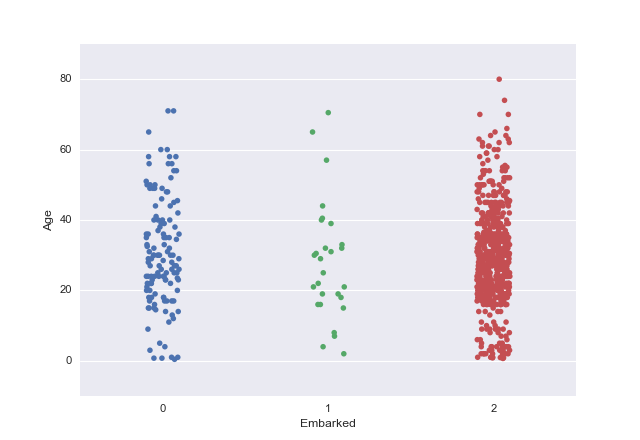

In [6]:
plt.figure()
sns.stripplot(x="Embarked", y="Age", data=tdf, jitter=True);

So, what's interesting about this? 
* There was only a few people over 60 on Titanic
* Not many children either
* Not many people embarked in Queenstown

<IPython.core.display.Javascript object>


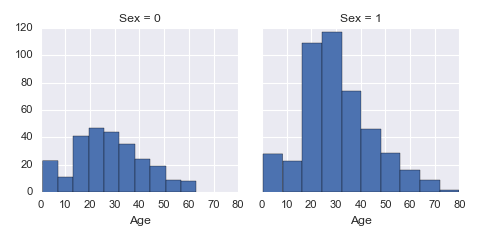

In [7]:
sns.FacetGrid(tdf, col="Sex").map(plt.hist, "Age")

Apparently, more males than females on board. Males were typically aged 20 to 40.

<IPython.core.display.Javascript object>


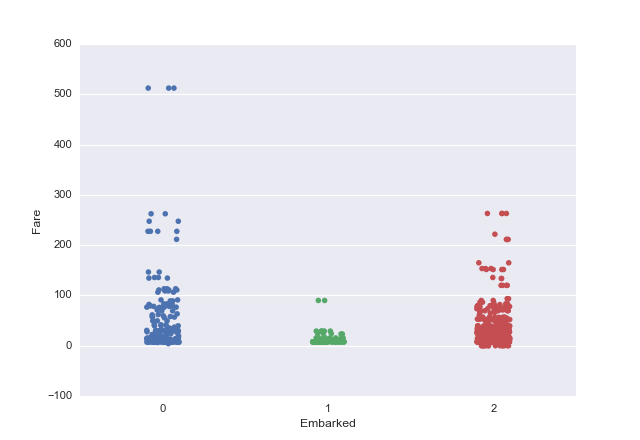

In [8]:
plt.figure()
sns.stripplot(x="Embarked", y="Fare",data=tdf, jitter=True);

We see that passengers that embarked in Queenstown bought the cheapest tickets except for 2 persons who paid nearly 100 pounds each.

## Missing Values

What to do about the missing values? Let's check how manuy of these we've got.

In [9]:
tdf.count()-len(tdf.index)  # this returns the number of missing observations in each column

Survived      0
Pclass        0
Sex           0
Age        -177
SibSp         0
Parch         0
Fare          0
Embarked     -2
Title         0
dtype: int64

All looks good except **Age**. And there are 2 values missing in **Embarked**. It's not obvious what we should do with **Embarked** and if it's important at all. However, we do need to deal with **Age**. We could just set all absent age values to 0 or ignore all records where age is not available. Or, we could approximate the age based on Title. How often do we see records with no age but some title present?

In [10]:
len(tdf[tdf["Age"].isnull() & tdf["Title"].notnull()].index)

177

Note that if we manage to approximate **Age** from **Title**, we will have 714+177=891 records with **Age**, i.e. we will fill in all the ages this way. Let's calculate average age depending on **Title**.

In [11]:
def get_age_from_title(df):
    
    aver_age_miss = round(df[~df["Age"].isnull()  & (df["Title"].str.strip().isin(["Miss","Ms"]))]["Age"].mean(),1)
    aver_age_mrs = round(df[~df["Age"].isnull()  & (df["Title"].str.strip().isin(["Mrs"]))]["Age"].mean(),1)
    aver_age_mr = round(df[~df["Age"].isnull()  & (df["Title"].str.strip().isin(["Mr"]))]["Age"].mean(),1)
    
    if np.sum(df["Title"].str.strip().isin(["Master"])) > 0:
        
        aver_age_master = round(df[~df["Age"].isnull()  & (df["Title"].str.strip().isin(["Master"]))]["Age"].mean(),1)
        master_idx = df["Title"].str.strip().isin(["Master"])
        df.loc[master_idx, "Age"] = df.loc[master_idx, "Age"].fillna(aver_age_master)
    
    same_as_mrs = ["Mrs","Mme","the Countess","Lady","Dona"]
    same_as_mr = ["Capt","Col","Don","Mr","Jonkheer","Major","Rev","Sir","Dr"]
    same_as_ms = ["Ms","Miss","Mlle"]
    
    miss_idx = df["Title"].str.strip().isin(same_as_ms)
   
    mr_idx = df["Title"].str.strip().isin(same_as_mr)
    mrs_idx = df["Title"].str.strip().isin(same_as_mrs)
    
    df.loc[miss_idx, "Age"] = df.loc[miss_idx, "Age"].fillna(aver_age_miss)
    df.loc[mr_idx,"Age"] = df.loc[mr_idx,"Age"].fillna(aver_age_mr)
    df.loc[mrs_idx,"Age"] = df.loc[mrs_idx,"Age"].fillna(aver_age_mrs)
    
    return df
    
    

In [12]:
tdf = get_age_from_title(tdf)
tdf["Embarked"] = tdf["Embarked"].fillna(2)
tdf.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,2,Mr
1,1,1,0,38.0,1,0,71.2833,0,Mrs
2,1,3,0,26.0,0,0,7.9250,2,Miss
3,1,1,0,35.0,1,0,53.1000,2,Mrs
4,0,3,1,35.0,0,0,8.0500,2,Mr


## Prediction

Split training data into the training and testing datasets. We will not be using **Title** and **Deck** for prediction.

In [14]:
vars_for_prediction = ["Pclass","Sex","Age","SibSp","Parch","Fare"]

from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()

X = tdf[vars_for_prediction]  # variables
y = tdf['Survived']  # outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
X_train[["Age","Fare"]] = stdsc.fit_transform(X_train[["Age","Fare"]])
X_test[["Age","Fare"]] = stdsc.fit_transform(X_test[["Age","Fare"]])

X_train.head()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,Pclass,Sex,Age,SibSp,Parch,Fare
333,3,1,-1.015195,2,0,-0.292785
662,1,1,1.295137,0,0,-0.144541
382,3,1,0.177235,0,0,-0.489631
331,1,1,1.183347,0,0,-0.087636
149,2,1,0.922503,0,0,-0.390475


### Logictic Regression

In [15]:
lr_parameters = {'penalty':['l2','l1'],'C':np.arange(0.1,1.0,0.1).tolist()}
lr = LogisticRegression()
lrc = GridSearchCV(lr, lr_parameters)
lrc.fit(X_train, y_train)
print('Training accuracy:', lrc.score(X_train, y_train))
print('Testing accuracy:', lrc.score(X_test, y_test))

Training accuracy: 0.783707865169
Testing accuracy: 0.843575418994


### Decision Tree

In [16]:
dt_parameters = {'min_samples_leaf': np.arange(0.05,0.5,0.025).tolist()}
clf = tree.DecisionTreeClassifier(splitter="random")
dtc = GridSearchCV(clf, dt_parameters)
dtc.fit(X_train, y_train)
print(accuracy_score(y_test, dtc.predict(X_test)))

0.832402234637


### Naive Bayes

In [17]:
nbc = GaussianNB()
nbc.fit(X_train, y_train)
print(accuracy_score(y_test, nbc.predict(X_test)))

0.815642458101


### RandomForests

In [18]:
rf_parameters = {'n_estimators': np.arange(1,100,1).tolist(),'min_weight_fraction_leaf':np.arange(0.1,0.5,0.1).tolist()}
rf = RandomForestClassifier(max_features='sqrt')
rfc = GridSearchCV(rf, rf_parameters)
rfc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_weight_fraction_leaf': [0.1, 0.2, 0.30000000000000004, 0.4], 'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]},
       pre_dispatch='2*

In [19]:
print(accuracy_score(y_test, rfc.predict(X_test)))
print(rfc.best_params_)

0.804469273743
{'n_estimators': 40, 'min_weight_fraction_leaf': 0.1}


In [20]:
best_rf = rfc.best_estimator_
best_rf.fit(X_train, y_train)
print(accuracy_score(y_test, best_rf.predict(X_test)))
print(best_rf.feature_importances_)

0.804469273743
[ 0.15814935  0.58147859  0.06194081  0.0196612   0.00981366  0.16895639]


## Extra Trees

In [21]:
xt_parameters = {"n_estimators":np.arange(1,50,1).tolist(), "min_samples_split":np.arange(1,20,1).tolist() }
xt = ExtraTreesClassifier(max_depth=None, random_state=0)
xtc = GridSearchCV(xt, xt_parameters)
xtc.fit(X_train, y_train)
print(accuracy_score(y_test, xtc.predict(X_test)))

0.837988826816


In [25]:
testing_df = transform_data(testing_df)
testing_df = get_age_from_title(testing_df)
testing_df[["Age","Fare"]] = stdsc.fit_transform(testing_df[["Age","Fare"]])

Y_pred = xtc.best_estimator_.predict(testing_df)  # note we use the RandomForests model here
print("predicted {} survival outcomes".format(len(Y_pred)))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [132]:
Y_pred = xtc.best_estimator_.predict(X_train_std)  # note we use the RandomForests model here
print("predicted {} survival outcomes".format(len(Y_pred)))

predicted 712 survival outcomes


Format precistions for submission. Recall that we have to submit a .csv with 2 columns, PassengerID and Survived.

In [29]:
submission_df = pd.DataFrame(columns=["PassengerId","Survived"])
submission_df["PassengerId"] = testing_df["PassengerId"]
submission_df["Survived"] = Y_pred
submission_df.head()

# save this data frame to a .csv file
submission_df.to_csv("titanic_submission.csv",index=False)

This looks right. Next step - submit :)